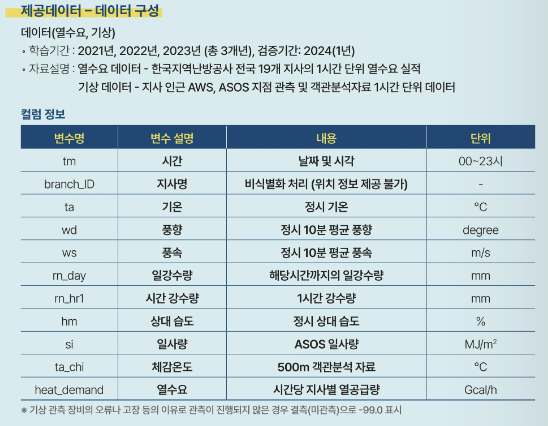

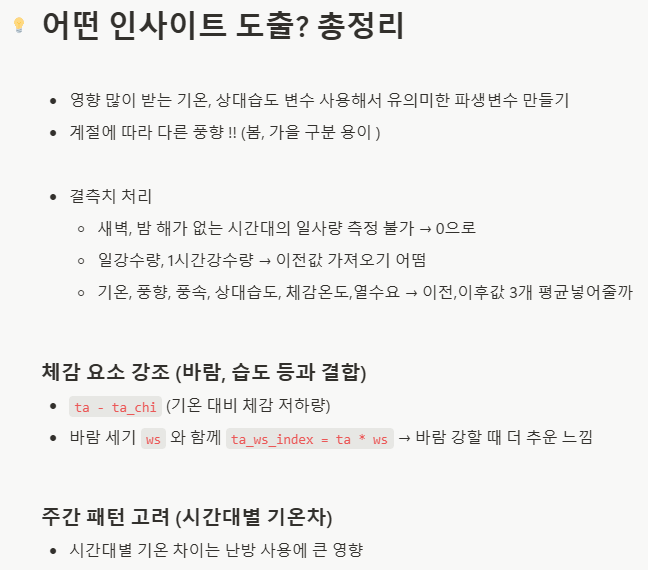

## 지역난방 열수요와 날씨 빅데이터를 융합한 열수요 예측

## 패키지 & 데이터 로드

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# pip install missingno
import missingno

In [5]:
heat = pd.read_csv("C:/Users/USER/OneDrive/바탕 화면/내 자료/4-1준비/체크난방/train_heat.csv", index_col=0)
heat

,train_heat.tm,train_heat.branch_id,train_heat.ta,train_heat.wd,train_heat.ws,train_heat.rn_day,train_heat.rn_hr1,train_heat.hm,train_heat.si,train_heat.ta_chi,train_heat.heat_demand
1,2021010101,A,-10.1,78.3,0.5,0.0,0.0,68.2,-99.0,-8.2,281
2,2021010102,A,-10.2,71.9,0.6,0.0,0.0,69.9,-99.0,-8.6,262
3,2021010103,A,-10.0,360.0,0.0,0.0,0.0,69.2,-99.0,-8.8,266
4,2021010104,A,-9.3,155.9,0.5,0.0,0.0,65.0,-99.0,-8.9,285
5,2021010105,A,-9.0,74.3,1.9,0.0,0.0,63.5,-99.0,-9.2,283
...,...,...,...,...,...,...,...,...,...,...,...
499297,2023123119,S,3.2,233.5,0.4,2.5,0.0,91.5,-99.0,2.8,34
499298,2023123120,S,2.9,227.4,0.1,2.5,0.0,92.1,-99.0,2.7,35
499299,2023123121,S,2.1,360.0,0.0,2.5,0.0,93.3,-99.0,1.4,35
499300,2023123122,S,2.2,30.0,1.4,2.5,0.0,95.5,-99.0,1.3,40


In [62]:
# 컬럼명에서 train_heat. 제거
heat.columns = heat.columns.str.replace("train_heat.", "", regex=False)
heat.head(2)

,tm,branch_id,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,heat_demand
1,2021010101,A,-10.1,78.3,0.5,0.0,0.0,68.2,-99.0,-8.2,281
2,2021010102,A,-10.2,71.9,0.6,0.0,0.0,69.9,-99.0,-8.6,262


In [5]:
heat.shape
# 499301개의 데이터, 11개의 feature

(499301, 11)

In [6]:
heat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 499301 entries, 1 to 499301
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   tm           499301 non-null  int64  
 1   branch_id    499301 non-null  object 
 2   ta           499301 non-null  float64
 3   wd           499301 non-null  float64
 4   ws           499301 non-null  float64
 5   rn_day       499301 non-null  float64
 6   rn_hr1       499301 non-null  float64
 7   hm           499301 non-null  float64
 8   si           499301 non-null  float64
 9   ta_chi       499301 non-null  float64
 10  heat_demand  499301 non-null  int64  
dtypes: float64(8), int64(2), object(1)
memory usage: 45.7+ MB


- object 처리, 정규화, 수치자료 이용 파생변수 생성, 날짜변수, 이상치확인

In [63]:
# 날짜 데이터를 데이트타임으로 변경
heat['tm'] = pd.to_datetime(heat['tm'].astype(str), format="%Y%m%d%H")

In [8]:
heat['tm'] # 2021-01-01부터 2023-12-31까지의 데이터

1        2021-01-01 01:00:00
2        2021-01-01 02:00:00
3        2021-01-01 03:00:00
4        2021-01-01 04:00:00
5        2021-01-01 05:00:00
                 ...        
499297   2023-12-31 19:00:00
499298   2023-12-31 20:00:00
499299   2023-12-31 21:00:00
499300   2023-12-31 22:00:00
499301   2023-12-31 23:00:00
Name: tm, Length: 499301, dtype: datetime64[ns]

- 계절의 영향? (월별로 나누기)
- 시각의 영향? (아침, 점심, 저녁 시간간)
- 연도의 영향? 

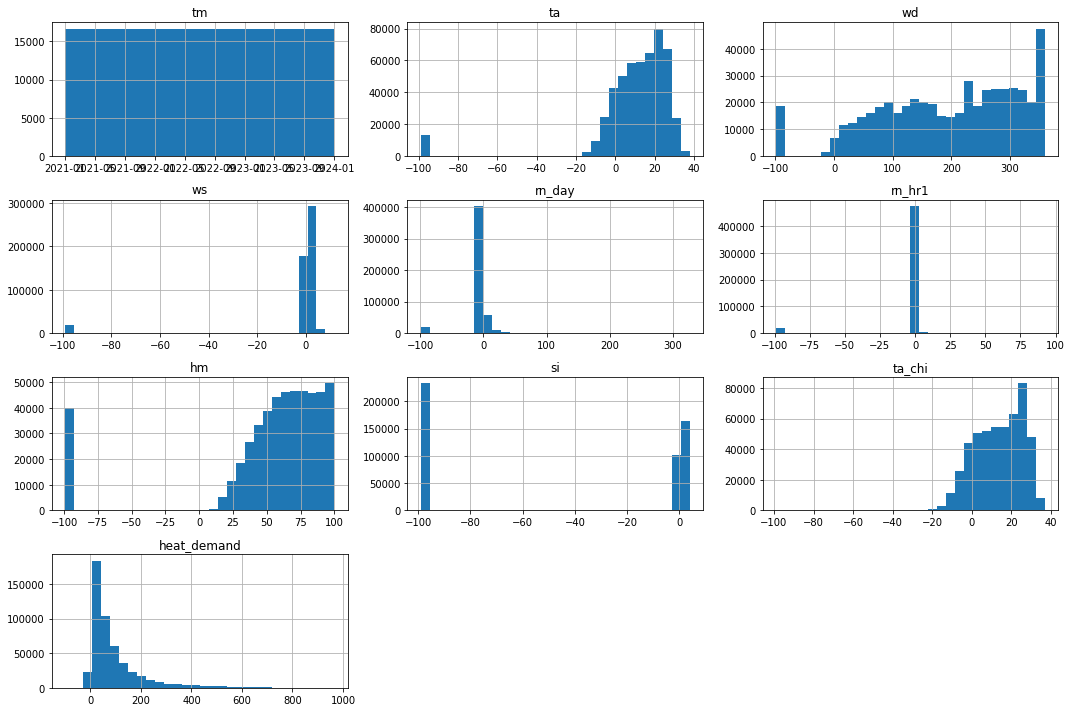

In [9]:
heat.hist(figsize=(15, 10), bins=30)
plt.tight_layout()
plt.show()

- -100근처에서 이상치 값이 나타남 (결측치로 확인됨)

## 결측치 확인
- -99로 저장되어 있음

In [64]:
len(heat[heat.isin([-99]).any(axis=1)])
# 263069개의 결측치 -> na로 대체할래

263069

In [65]:
heat = heat.replace(-99, np.nan)

In [66]:
heat.isnull().sum()

tm                  0
branch_id           0
ta              12997
wd              18815
ws              18815
rn_day          18626
rn_hr1          19154
hm              39717
si             232922
ta_chi             20
heat_demand        23
dtype: int64

In [13]:
# 비율로 확인
heat.isnull().mean()

tm             0.000000
branch_id      0.000000
ta             0.026030
wd             0.037683
ws             0.037683
rn_day         0.037304
rn_hr1         0.038362
hm             0.079545
si             0.466496
ta_chi         0.000040
heat_demand    0.000046
dtype: float64

- si에 유난히 결측치 많음!! -> 해가 져있는 시간대 (새벽, 밤에는 일사량이 없어서 null값으로 한듯.)

In [22]:
heat[~heat['si'].isnull()]

,tm,branch_id,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,heat_demand
8,2021-01-01 08:00:00,A,-8.6,88.9,1.2,0.0,0.0,63.8,0.00,-8.4,284.0
9,2021-01-01 09:00:00,A,-7.4,71.6,1.3,0.0,0.0,61.2,0.27,-7.5,290.0
10,2021-01-01 10:00:00,A,-4.7,157.5,0.5,0.0,0.0,50.4,0.76,-5.3,285.0
11,2021-01-01 11:00:00,A,-2.6,184.2,0.9,0.0,0.0,41.5,1.40,-3.1,277.0
12,2021-01-01 12:00:00,A,-2.2,232.4,1.2,0.0,0.0,46.1,1.74,-1.6,269.0
...,...,...,...,...,...,...,...,...,...,...,...
499292,2023-12-31 14:00:00,S,4.4,288.7,2.6,2.5,0.0,86.6,0.57,2.0,25.0
499293,2023-12-31 15:00:00,S,4.4,287.0,2.4,2.5,0.0,86.7,0.50,2.6,26.0
499294,2023-12-31 16:00:00,S,4.9,302.5,2.2,2.5,0.0,84.8,0.31,3.0,29.0
499295,2023-12-31 17:00:00,S,4.4,284.1,1.2,2.5,0.0,87.3,0.16,4.4,30.0


In [21]:
heat[499280:] #아침시간대,밤시간대로 나타남. 

,tm,branch_id,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,heat_demand
499281,2023-12-31 03:00:00,S,3.0,60.3,0.8,0.5,0.0,97.9,NaN,2.7,21.0
499282,2023-12-31 04:00:00,S,2.8,360.0,0.0,0.5,0.0,98.0,NaN,2.7,20.0
499283,2023-12-31 05:00:00,S,3.8,122.1,0.5,0.5,0.0,98.0,NaN,3.0,18.0
499284,2023-12-31 06:00:00,S,4.4,127.1,3.3,0.5,0.0,98.0,NaN,1.8,24.0
499285,2023-12-31 07:00:00,S,4.7,256.7,6.9,2.5,2.0,98.2,NaN,0.5,30.0
499286,2023-12-31 08:00:00,S,3.3,269.9,3.5,2.5,0.0,98.1,0.00,0.0,34.0
499287,2023-12-31 09:00:00,S,3.2,282.7,4.5,2.5,0.0,95.6,0.06,-0.2,36.0
499288,2023-12-31 10:00:00,S,3.7,285.9,4.0,2.5,0.0,92.8,0.16,0.4,32.0
499289,2023-12-31 11:00:00,S,3.9,284.3,3.9,2.5,0.0,88.7,0.19,0.6,27.0
499290,2023-12-31 12:00:00,S,3.8,288.0,3.0,2.5,0.0,89.1,0.18,1.0,30.0


### 강수량, 일강수량 -> 없어서 결측치가 되었나?
#### 0인거랑 결측치의 차이 살펴보기

In [27]:
heat[heat['rn_day']==0]

,tm,branch_id,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,heat_demand
1,2021-01-01 01:00:00,A,-10.1,78.3,0.5,0.0,0.0,68.2,NaN,-8.2,281.0
2,2021-01-01 02:00:00,A,-10.2,71.9,0.6,0.0,0.0,69.9,NaN,-8.6,262.0
3,2021-01-01 03:00:00,A,-10.0,360.0,0.0,0.0,0.0,69.2,NaN,-8.8,266.0
4,2021-01-01 04:00:00,A,-9.3,155.9,0.5,0.0,0.0,65.0,NaN,-8.9,285.0
5,2021-01-01 05:00:00,A,-9.0,74.3,1.9,0.0,0.0,63.5,NaN,-9.2,283.0
...,...,...,...,...,...,...,...,...,...,...,...
499264,2023-12-30 10:00:00,S,0.9,18.3,1.8,0.0,0.0,87.6,0.10,0.9,36.0
499265,2023-12-30 11:00:00,S,0.9,355.3,0.4,0.0,0.0,89.9,0.17,0.9,29.0
499266,2023-12-30 12:00:00,S,1.9,65.4,0.6,0.0,0.0,84.0,0.19,1.3,35.0
499267,2023-12-30 13:00:00,S,1.7,211.3,0.5,0.0,0.0,87.4,0.12,1.3,33.0


In [26]:
heat[heat['rn_day'].isnull()]

,tm,branch_id,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,heat_demand
2096,2021-03-29 08:00:00,A,8.3,148.4,0.9,NaN,NaN,89.6,0.34,8.9,145.0
2097,2021-03-29 09:00:00,A,9.7,144.6,1.3,NaN,NaN,77.8,0.98,10.0,126.0
2098,2021-03-29 10:00:00,A,11.1,107.2,2.7,NaN,NaN,53.7,1.83,11.5,103.0
2099,2021-03-29 11:00:00,A,13.1,133.0,2.7,NaN,NaN,39.7,2.58,12.8,97.0
2100,2021-03-29 12:00:00,A,14.3,121.7,2.8,NaN,NaN,33.3,2.95,13.9,84.0
...,...,...,...,...,...,...,...,...,...,...,...
498113,2023-11-12 11:00:00,S,NaN,NaN,NaN,NaN,NaN,NaN,1.80,1.7,17.0
498114,2023-11-12 12:00:00,S,NaN,NaN,NaN,NaN,NaN,NaN,2.11,1.7,15.0
498115,2023-11-12 13:00:00,S,NaN,NaN,NaN,NaN,NaN,NaN,2.17,2.7,15.0
498116,2023-11-12 14:00:00,S,NaN,NaN,NaN,NaN,NaN,NaN,2.03,3.1,15.0


In [33]:
heat[2090:2125]

,tm,branch_id,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,heat_demand
2091,2021-03-29 03:00:00,A,7.9,154.9,2.4,0.0,0.0,96.5,NaN,8.6,92.0
2092,2021-03-29 04:00:00,A,7.5,155.3,1.2,0.0,0.0,95.9,NaN,7.7,96.0
2093,2021-03-29 05:00:00,A,7.7,148.4,0.9,0.0,0.0,95.5,NaN,8.4,113.0
2094,2021-03-29 06:00:00,A,7.8,161.1,1.1,0.0,0.0,95.3,NaN,8.5,123.0
2095,2021-03-29 07:00:00,A,7.9,147.3,1.3,0.0,0.0,92.6,0.02,8.5,147.0
2096,2021-03-29 08:00:00,A,8.3,148.4,0.9,NaN,NaN,89.6,0.34,8.9,145.0
2097,2021-03-29 09:00:00,A,9.7,144.6,1.3,NaN,NaN,77.8,0.98,10.0,126.0
2098,2021-03-29 10:00:00,A,11.1,107.2,2.7,NaN,NaN,53.7,1.83,11.5,103.0
2099,2021-03-29 11:00:00,A,13.1,133.0,2.7,NaN,NaN,39.7,2.58,12.8,97.0
2100,2021-03-29 12:00:00,A,14.3,121.7,2.8,NaN,NaN,33.3,2.95,13.9,84.0


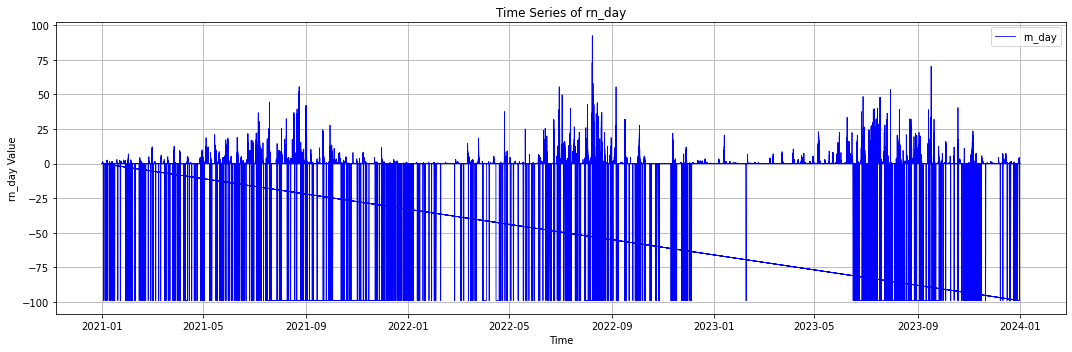

In [40]:
# 그래프 그리기 #-99일때 그림  
plt.figure(figsize=(15, 5))
plt.plot(heat['tm'], heat['rn_hr1'], label='rn_day', color='blue', linewidth=0.8)

plt.title('Time Series of rn_day')
plt.xlabel('Time')
plt.ylabel('rn_day Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

패턴이 보이는 것도 아니고, 2023년도에만 텅 비어있음. 
그리고 0인 값이랑도 공존하는 거 보면 강수량이 없는 날을 null로 넣은 건 아닌 것 같음 -> 그랬다면 0으로 했겠지
그렇다면, null값이 나오기 직전에 혹시 다 0이라면 -> 그냥 0으로 해도되지 않을까?

In [56]:
# NaN이 있는 위치 찾기
nan_indices = heat['rn_day'][heat['rn_day'].isnull()].index

# NaN 직전 인덱스 구하기
previous_indices = nan_indices - 1

# 범위 벗어나는 인덱스 제거
previous_indices = previous_indices[previous_indices >= 0]

# NaN 바로 직전 값들 보기
heat.loc[previous_indices, ['rn_day']]
heat.loc[previous_indices, 'rn_day'].value_counts()[1:]

rn_day
1.0     23
1.5     14
2.5      9
2.0      9
5.0      7
        ..
64.9     1
1.2      1
3.9      1
12.8     1
44.0     1
Name: count, Length: 68, dtype: int64

<Axes: >

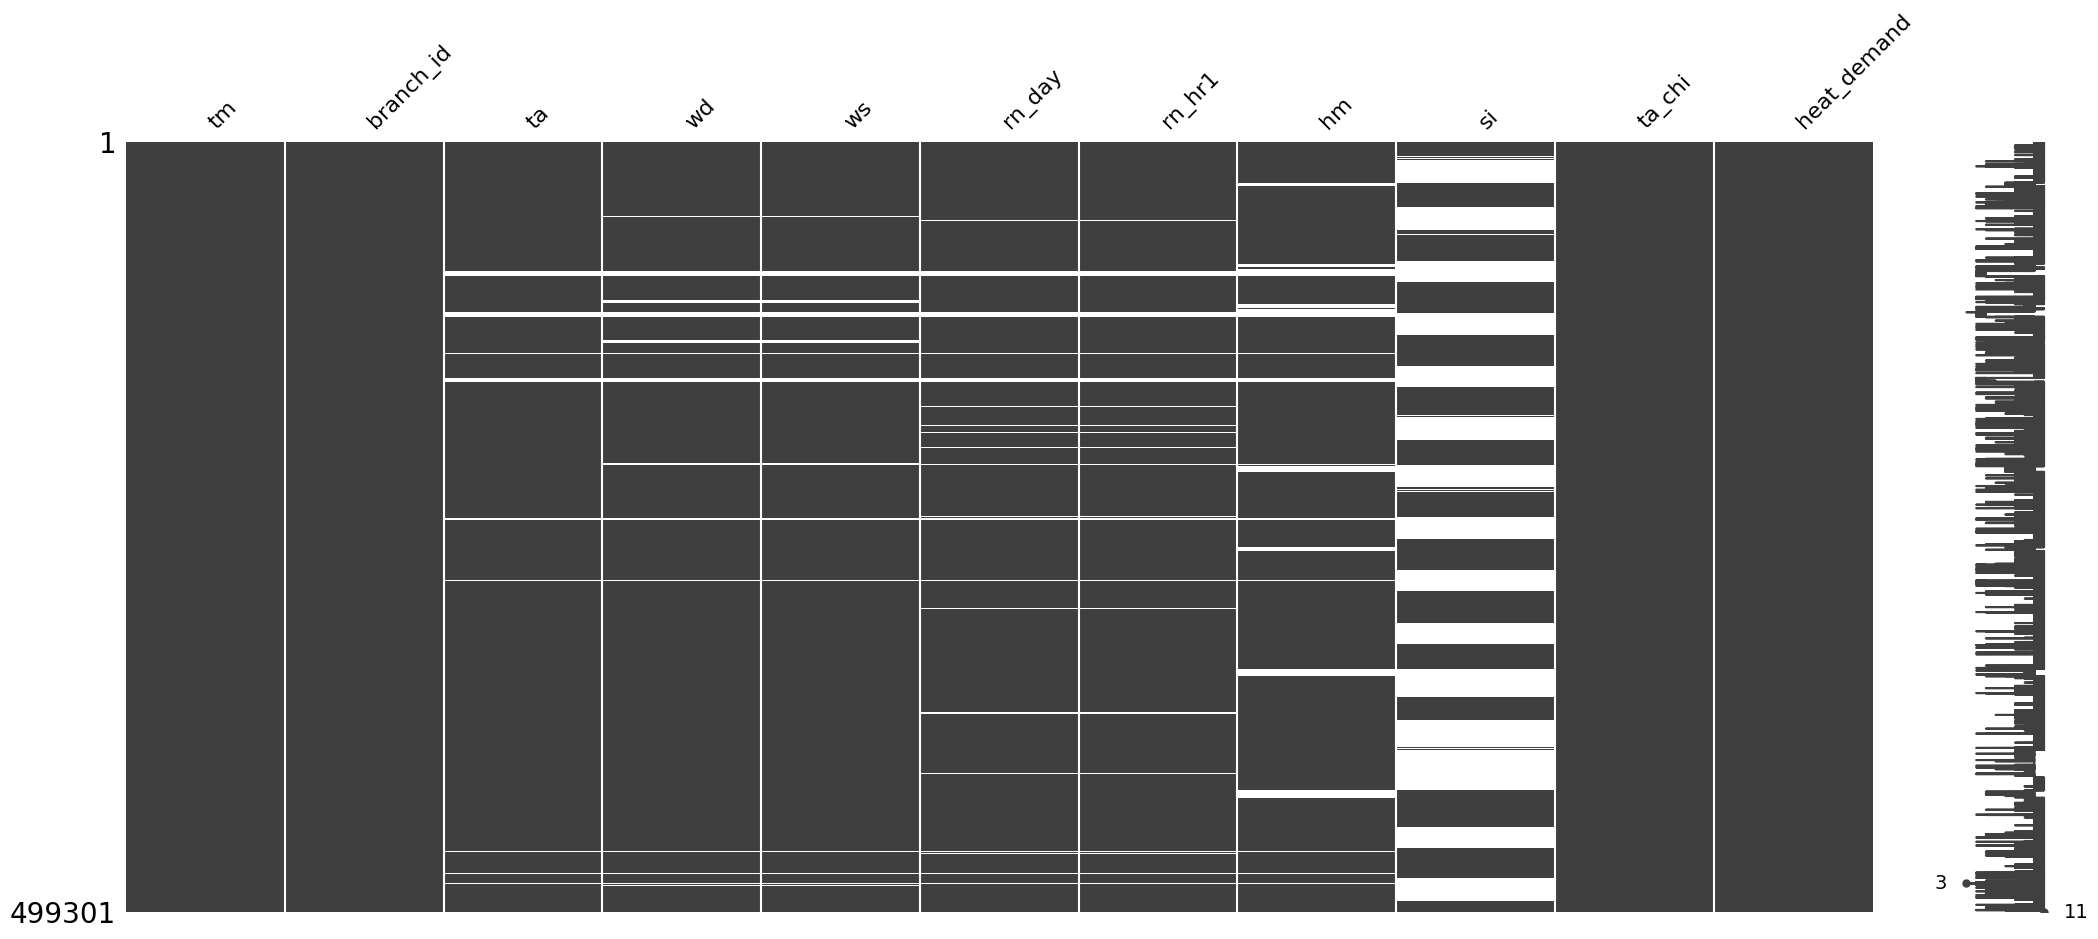

In [ ]:
# 시각화로 확인
missingno.matrix(heat)

# 피처 하나씩 보기

## branch_id

In [68]:
heat['branch_id'].nunique()
# 19개의 지사

19

In [69]:
heat['branch_id'].value_counts()
# 관측값의 개수는 모두 같음.

branch_id
A    26279
K    26279
R    26279
Q    26279
P    26279
O    26279
N    26279
M    26279
L    26279
J    26279
B    26279
I    26279
H    26279
G    26279
F    26279
E    26279
D    26279
C    26279
S    26279
Name: count, dtype: int64

## ta (기온)

📌 기본 통계량:
count    486304.000000
mean         13.550747
std          10.855174
min         -19.700000
25%           5.200000
50%          14.700000
75%          22.700000
max          37.800000
Name: ta, dtype: float64

📌 결측치 개수: 12997


<ipython-input-73-067cb098daee>:19: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  plt.tight_layout()
<ipython-input-73-067cb098daee>:19: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from current font.
  plt.tight_layout()
<ipython-input-73-067cb098daee>:19: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  plt.tight_layout()
<ipython-input-73-067cb098daee>:19: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  plt.tight_layout()
<ipython-input-73-067cb098daee>:19: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  plt.tight_layout()
<ipython-input-73-067cb098daee>:19: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  plt.tight_layout()
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


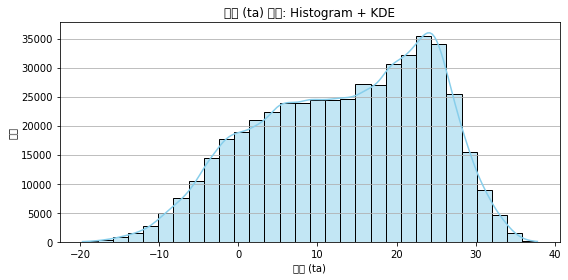

<ipython-input-73-067cb098daee>:26: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  plt.tight_layout()
<ipython-input-73-067cb098daee>:26: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from current font.
  plt.tight_layout()
<ipython-input-73-067cb098daee>:26: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  plt.tight_layout()
<ipython-input-73-067cb098daee>:26: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  plt.tight_layout()
<ipython-input-73-067cb098daee>:26: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from current font.
  plt.tight_layout()
<ipython-input-73-067cb098daee>:26: UserWarning: Glyph 53456 (\N{HANGUL SYLLABLE TAM}) missing from current font.
  plt.tight_layout()
<ipython-input-73-067cb098daee>:26: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  plt.tight_layout()
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylab

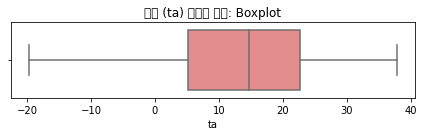

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 기본 통계 확인
print("📌 기본 통계량:")
print(heat['ta'].describe())

# 2. 결측치 확인
print(f"\n📌 결측치 개수: {heat['ta'].isna().sum()}")

# 3. 히스토그램 + 커널 밀도
plt.figure(figsize=(8, 4))
sns.histplot(heat['ta'], kde=True, bins=30, color='skyblue')
plt.title('기온 (ta) 분포: Histogram + KDE')
plt.xlabel('기온 (ta)')
plt.ylabel('빈도')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 4. 박스플롯 (이상치 탐지용)
plt.figure(figsize=(6, 2))
sns.boxplot(x=heat['ta'], color='lightcoral')
plt.title('기온 (ta) 이상치 탐지: Boxplot')
plt.tight_layout()
plt.show()

# 5. 시계열 시각화 (날짜 컬럼이 있을 경우: '날짜' 또는 'date')
if '날짜' in heat.columns or 'date' in heat.columns:
    time_col = '날짜' if '날짜' in heat.columns else 'date'
    heat[time_col] = pd.to_datetime(heat[time_col])
    heat_sorted = heat.sort_values(by=time_col)

    plt.figure(figsize=(12, 4))
    plt.plot(heat_sorted[time_col], heat_sorted['ta'], color='steelblue')
    plt.title('시간에 따른 기온 (ta) 변화')
    plt.xlabel('시간')
    plt.ylabel('기온 (ta)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\s

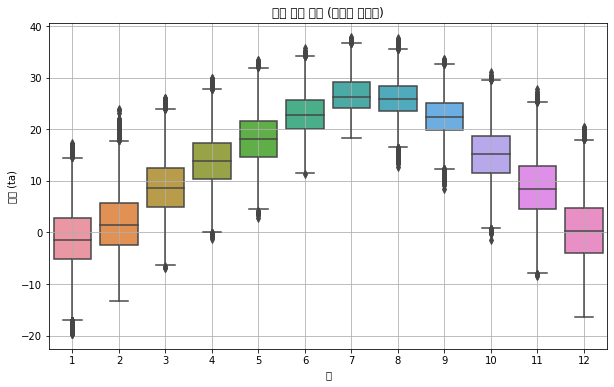

c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 48143 (\N{HANGUL SYLLABLE MIC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 54253 (\N{HANGUL SYLLABLE POG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 50684 (\N{HANGUL SYLLABLE YEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\si

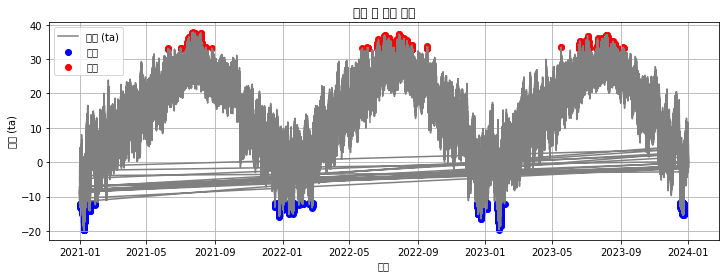

c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


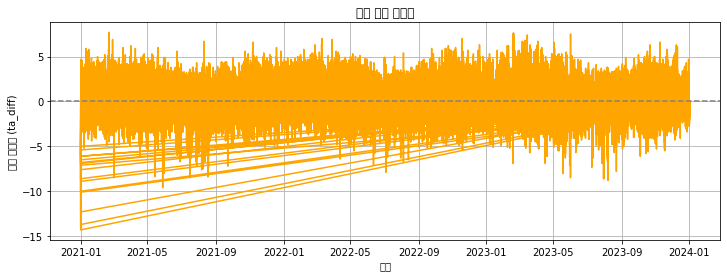

c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 50676 (\N{HANGUL SYLLABLE YEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


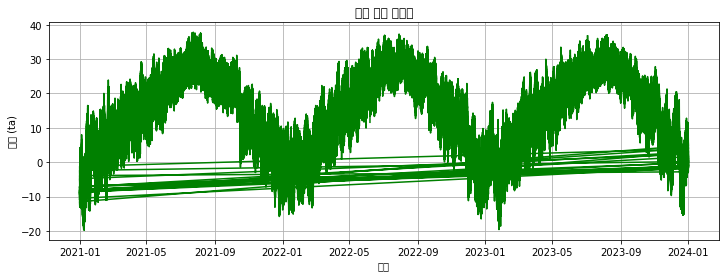

In [75]:
# 2. 날짜 기반 파생 컬럼
# 연, 월, 일, 시, 분, 초 컬럼 추출
heat['year'] = heat['tm'].dt.year
heat['month'] = heat['tm'].dt.month
heat['day'] = heat['tm'].dt.day
heat['hour'] = heat['tm'].dt.hour

# 3. 월별 기온 분포 (계절성 확인)
plt.figure(figsize=(10, 6))
sns.boxplot(x='month', y='ta', data=heat)
plt.title('월별 기온 분포 (기온의 계절성)')
plt.xlabel('월')
plt.ylabel('기온 (ta)')
plt.grid(True)
plt.show()

# 4. 한파 & 폭염 여부 파생변수 생성
# 기준: 한파 ≤ -12도, 폭염 ≥ 33도 (필요시 조정)
heat['cold_wave'] = heat['ta'] <= -12
heat['heat_wave'] = heat['ta'] >= 33

# 5. 한파/폭염 시각화
plt.figure(figsize=(12, 4))
plt.plot(heat['tm'], heat['ta'], label='기온 (ta)', color='gray')
plt.scatter(heat.loc[heat['cold_wave'], 'tm'], heat.loc[heat['cold_wave'], 'ta'], color='blue', label='한파')
plt.scatter(heat.loc[heat['heat_wave'], 'tm'], heat.loc[heat['heat_wave'], 'ta'], color='red', label='폭염')
plt.title('한파 및 폭염 구간')
plt.xlabel('날짜')
plt.ylabel('기온 (ta)')
plt.legend()
plt.grid(True)
plt.show()

# 6. 전체 기온 시계열
plt.figure(figsize=(12, 4))
plt.plot(heat['tm'], heat['ta'], label='기온 (ta)', color='green')
plt.title('전체 기온 시계열')
plt.xlabel('날짜')
plt.ylabel('기온 (ta)')
plt.grid(True)
plt.show()

## wd(풍향)

c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 54413 (\N{HANGUL SYLLABLE PUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 54693 (\N{HANGUL SYLLABLE HYANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


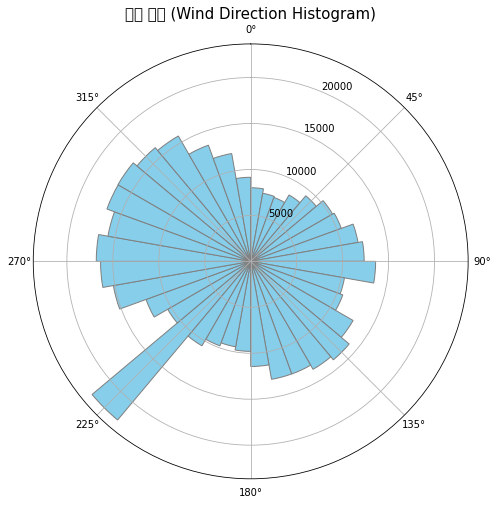

In [78]:
import numpy as np
import matplotlib.pyplot as plt

# wind direction 컬럼명 'wd'가 있다고 가정
wind_dir = heat['wd']

# 0~360도 범위로 10도 단위 구간 나누기
bins = np.arange(0, 370, 10)
wind_dir_bin = pd.cut(wind_dir, bins=bins, right=False)

# 각 구간 빈도 계산 및 정렬
wind_counts = wind_dir_bin.value_counts().sort_index()

# 라디안 각도 변환 (각 구간의 시작값 기준)
angles = np.deg2rad(bins[:-1])

# Polar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
bars = ax.bar(angles, wind_counts.values, width=np.deg2rad(10), bottom=0.0, align='edge',
              color='skyblue', edgecolor='gray')

ax.set_theta_zero_location('N')  # 0도(북쪽)를 위로
ax.set_theta_direction(-1)       # 시계방향으로 증가
ax.set_title('풍향 분포 (Wind Direction Histogram)', fontsize=15)

plt.show()


#### 월별 풍향 분포 그리기 (Polar plot)

<ipython-input-80-a54c7442b38d>:34: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from current font.
  plt.tight_layout()
<ipython-input-80-a54c7442b38d>:34: UserWarning: Glyph 54413 (\N{HANGUL SYLLABLE PUNG}) missing from current font.
  plt.tight_layout()
<ipython-input-80-a54c7442b38d>:34: UserWarning: Glyph 54693 (\N{HANGUL SYLLABLE HYANG}) missing from current font.
  plt.tight_layout()
<ipython-input-80-a54c7442b38d>:34: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  plt.tight_layout()
<ipython-input-80-a54c7442b38d>:34: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  plt.tight_layout()
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 54413 (\N{HANGUL SYLLABLE PUNG}) m

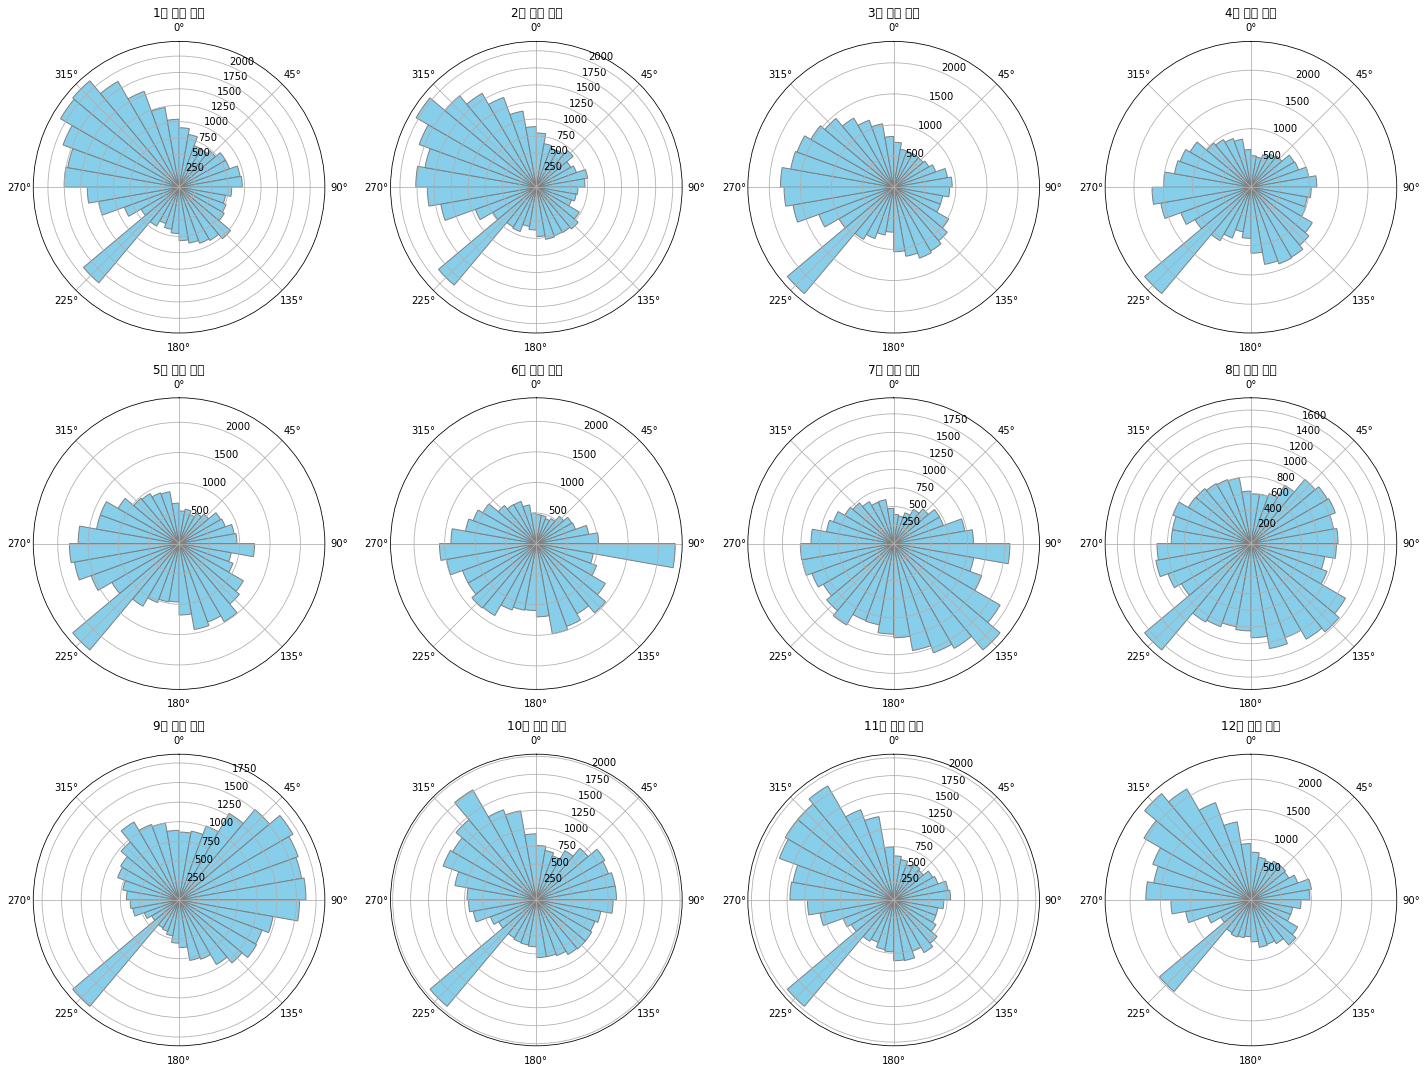

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 10도 단위 구간 설정
bins = np.arange(0, 370, 10)

# 월별 subplot 개수: 12개
fig, axes = plt.subplots(3, 4, figsize=(20, 15), subplot_kw={'projection': 'polar'})

for month in range(1, 13):
    ax = axes[(month-1)//4, (month-1)%4]
    
    # 해당 월 데이터 추출
    month_data = heat[heat['tm'].dt.month == month]['wd']
    
    # 10도 단위로 구간 나누기
    wind_dir_bin = pd.cut(month_data, bins=bins, right=False)
    
    # 각 구간 빈도 계산 및 정렬
    wind_counts = wind_dir_bin.value_counts().sort_index()
    
    # 라디안 각도 변환
    angles = np.deg2rad(bins[:-1])
    
    # Polar bar plot
    ax.bar(angles, wind_counts.values, width=np.deg2rad(10), bottom=0.0, align='edge',
           color='skyblue', edgecolor='gray')
    
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_title(f'{month}월 풍향 분포')

plt.tight_layout()
plt.show()


남서풍과 남동풍은 봄과 여름에 강함

가을에는 서풍과 남서풍이 강해짐

겨울에는 서풍과 북서풍이 우세

계절에 따라 풍향 분포가 뚜렷하게 달라지며, 이는 기후 특성과 연관 있음

남서풍(225도 부근)이 대부분 계절에서 두드러지는 특징



## ws(풍속)

count    480486.000000
mean          1.440149
std           1.185264
min           0.000000
25%           0.500000
50%           1.200000
75%           2.100000
max          11.900000
Name: ws, dtype: float64
18815


c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 54413 (\N{HANGUL SYLLABLE PUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 49549 (\N{HANGUL SYLLABLE SOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\si

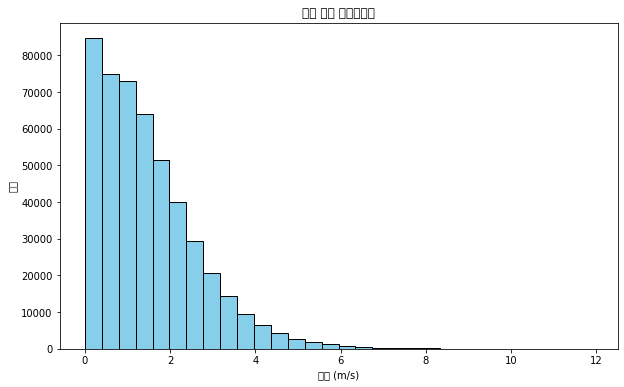

In [82]:
# 기본 통계량
print(heat['ws'].describe())

# 결측치 확인
print(heat['ws'].isnull().sum())

# 히스토그램(분포)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.hist(heat['ws'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('풍속 분포 히스토그램')
plt.xlabel('풍속 (m/s)')
plt.ylabel('빈도')
plt.show()

7이상인건 679개, 8이상인 건 229개
8부터는 풍속이 매우 강하다는 것. 이상치에 해당 (but유의미하니까.. )

In [103]:
heat['ws'][heat['ws'] > 7]

26422      9.2
26423      8.5
26424      7.9
26428      7.8
26429      8.0
          ... 
497974     8.3
497979     8.0
497980     9.1
497985     7.8
498741    10.2
Name: ws, Length: 679, dtype: float64

### 강풍 부는 기간 분석

3,6,12월에 강한 바람이 많이 붐.

강풍 데이터 수: 258


c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 54413 (\N{HANGUL SYLLABLE PUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 48156 (\N{HANGUL SYLLABLE BAL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\l

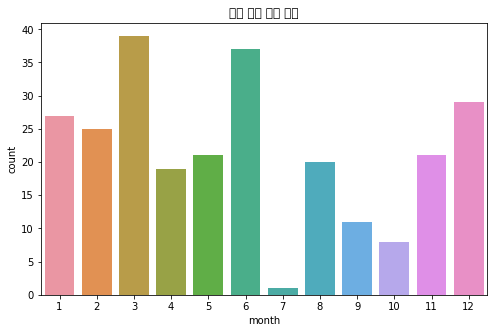

c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 54413 (\N{HANGUL SYLLABLE PUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 48156 (\N{HANGUL SYLLABLE BAL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\li

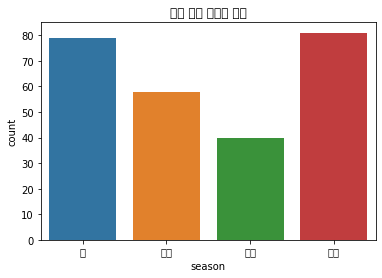

In [106]:
strong_wind = heat[heat['ws'] >= 8]
print(f"강풍 데이터 수: {len(strong_wind)}")

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.countplot(x='month', data=strong_wind)
plt.title('강풍 발생 월별 빈도')
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='season', data=strong_wind, order=['봄','여름','가을','겨울'])
plt.title('강풍 발생 계절별 빈도')
plt.show()


### 계절별 풍속

큰 차이 없음

c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 54413 (\N{HANGUL SYLLABLE PUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 49549 (\N{HANGUL SYLLABLE SOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\li

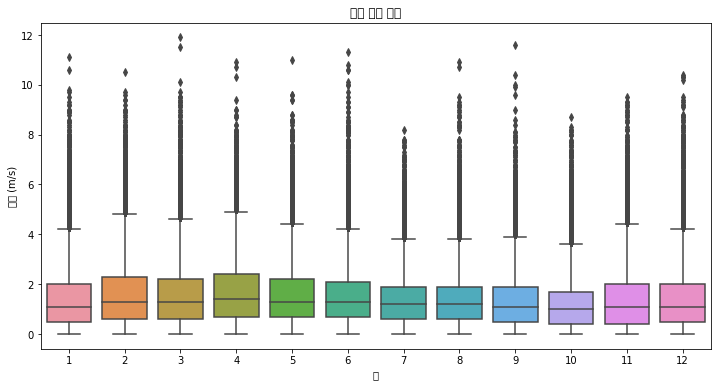

c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 54413 (\N{HANGUL SYLLABLE PUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 49549 (\N{HANGUL SYLLABLE SOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 51208 (\N{HANGUL SYLLABLE JEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\li

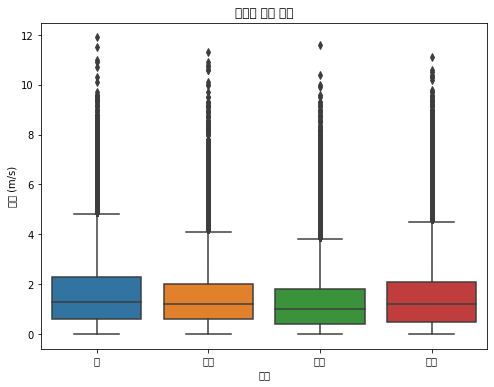

In [105]:
# 월별 풍속 평균과 분포
plt.figure(figsize=(12,6))
sns.boxplot(x='month', y='ws', data=heat)
plt.title('월별 풍속 분포')
plt.xlabel('월')
plt.ylabel('풍속 (m/s)')
plt.show()

# 계절 컬럼(이미 있으면 패스)
def get_season(month):
    if month in [12, 1, 2]:
        return '겨울'
    elif month in [3, 4, 5]:
        return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    else:
        return '가을'
heat['season'] = heat['tm'].dt.month.apply(get_season)

# 계절별 풍속 박스플롯
plt.figure(figsize=(8,6))
sns.boxplot(x='season', y='ws', data=heat, order=['봄','여름','가을','겨울'])
plt.title('계절별 풍속 분포')
plt.xlabel('계절')
plt.ylabel('풍속 (m/s)')
plt.show()


## hm(상대습도)

c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\s

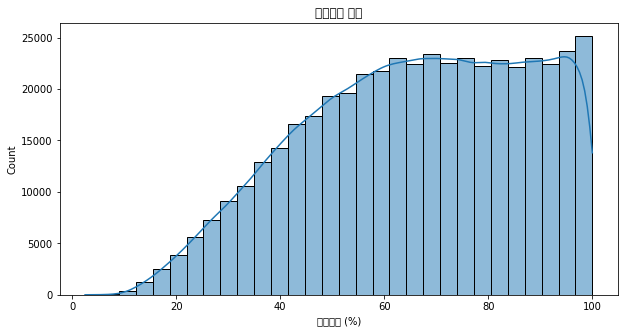

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(data=heat, x='hm', bins=30, kde=True)
plt.title('상대습도 분포')
plt.xlabel('상대습도 (%)')
plt.show()


c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 50676 (\N{HANGUL SYLLABLE YEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\si

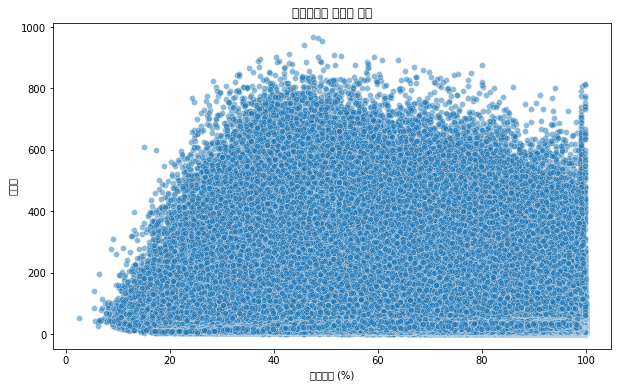

In [113]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=heat, x='hm', y='heat_demand', alpha=0.5)
plt.title('상대습도와 열수요 관계')
plt.xlabel('상대습도 (%)')
plt.ylabel('열수요')
plt.show()


## ta_chi(체감온도)

<ipython-input-119-e515aeff5235>:11: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from current font.
  plt.tight_layout()
<ipython-input-119-e515aeff5235>:11: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from current font.
  plt.tight_layout()
<ipython-input-119-e515aeff5235>:11: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from current font.
  plt.tight_layout()
<ipython-input-119-e515aeff5235>:11: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  plt.tight_layout()
<ipython-input-119-e515aeff5235>:11: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  plt.tight_layout()
<ipython-input-119-e515aeff5235>:11: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from current font.
  plt.tight_layout()
<ipython-input-119-e515aeff5235>:11: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from current font.
  plt.tight_layout()
<ipython-input-119-e515aeff5235>:11: UserWarning: Gly

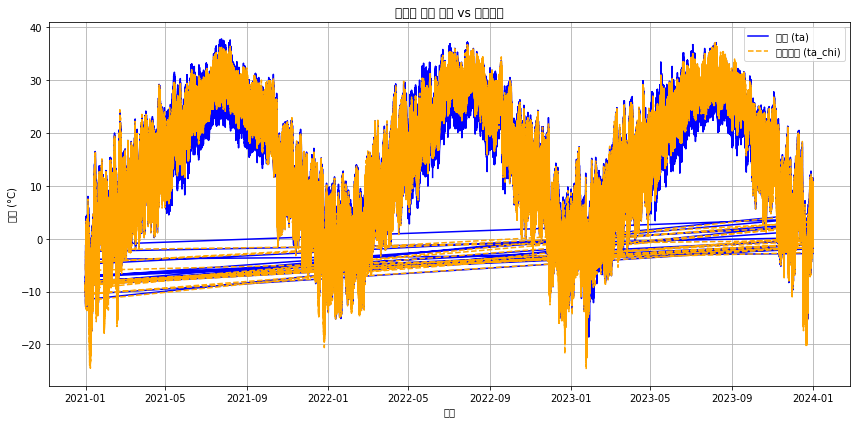

In [119]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(heat['tm'], heat['ta'], label='기온 (ta)', color='blue')
plt.plot(heat['tm'], heat['ta_chi'], label='체감온도 (ta_chi)', color='orange', linestyle='--')
plt.title('시간에 따른 기온 vs 체감온도')
plt.xlabel('날짜')
plt.ylabel('온도 (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


주로 5-9월에 체감온도와 실제 온도와 많은 차이를 보임 (여름)

## heat_demand(열수요_target)

<ipython-input-121-19c4c83cca6d>:9: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  plt.tight_layout()
<ipython-input-121-19c4c83cca6d>:9: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  plt.tight_layout()
<ipython-input-121-19c4c83cca6d>:9: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  plt.tight_layout()
<ipython-input-121-19c4c83cca6d>:9: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  plt.tight_layout()
<ipython-input-121-19c4c83cca6d>:9: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  plt.tight_layout()
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing fr

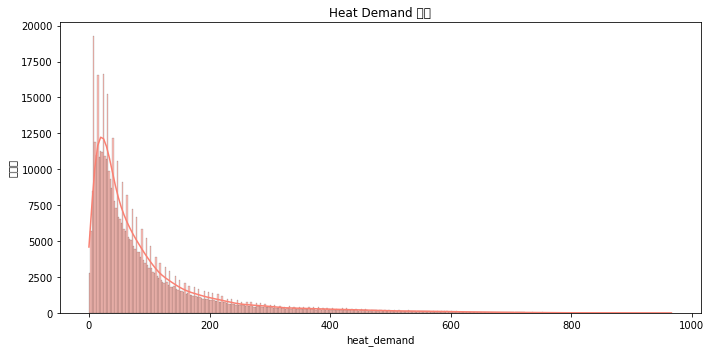

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.histplot(heat['heat_demand'], kde=True, color='salmon')
plt.title('Heat Demand 분포')
plt.xlabel('heat_demand')
plt.ylabel('빈도수')
plt.tight_layout()
plt.show()


<ipython-input-122-eddacd58bdb4>:6: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  plt.tight_layout()
<ipython-input-122-eddacd58bdb4>:6: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from current font.
  plt.tight_layout()
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


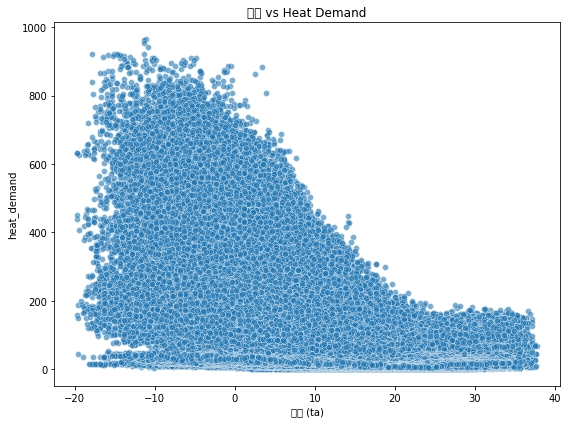

In [122]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=heat, x='ta', y='heat_demand', alpha=0.6)
plt.title('기온 vs Heat Demand')
plt.xlabel('기온 (ta)')
plt.ylabel('heat_demand')
plt.tight_layout()
plt.show()


기온이 -20℃에서 0℃ 사이일 때는 열수요가 최대 800~900 이상까지 올라감.

기온이 15~20℃ 이상이 되면, 열수요는 거의 100 이하 수준으로 떨어짐.

<ipython-input-123-d0743e058074>:6: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  plt.tight_layout()
<ipython-input-123-d0743e058074>:6: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from current font.
  plt.tight_layout()
<ipython-input-123-d0743e058074>:6: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from current font.
  plt.tight_layout()
<ipython-input-123-d0743e058074>:6: UserWarning: Glyph 46384 (\N{HANGUL SYLLABLE DDA}) missing from current font.
  plt.tight_layout()
<ipython-input-123-d0743e058074>:6: UserWarning: Glyph 47480 (\N{HANGUL SYLLABLE REUN}) missing from current font.
  plt.tight_layout()
<ipython-input-123-d0743e058074>:6: UserWarning: Glyph 54924 (\N{HANGUL SYLLABLE HOE}) missing from current font.
  plt.tight_layout()
<ipython-input-123-d0743e058074>:6: UserWarning: Glyph 44480 (\N{HANGUL SYLLABLE GWI}) missing from current font.
  plt.tight_layout()
<ipython-input-123-d0743e058074>:6: UserWarning: Glyph 526

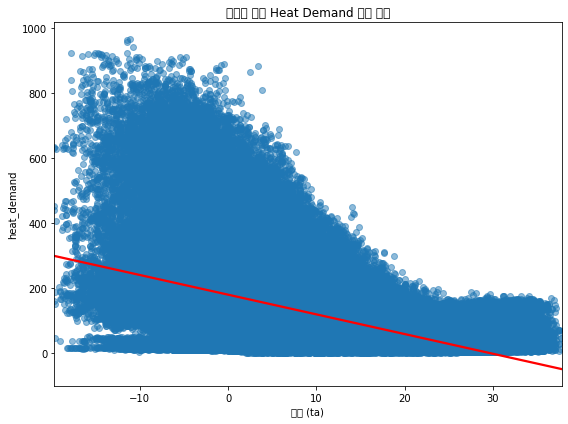

In [123]:
plt.figure(figsize=(8,6))
sns.regplot(data=heat, x='ta', y='heat_demand', scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('기온에 따른 Heat Demand 회귀 추세')
plt.xlabel('기온 (ta)')
plt.ylabel('heat_demand')
plt.tight_layout()
plt.show()


보면서 든 생각은 상식적으로 겨울엔 열수요가 많고 여름엔 적을 것임.

봄과 가을에서 드러나는 미세한 특징들을 잡아내면 더 정교해질 수 있을 것 같음. 

시간에

c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\si

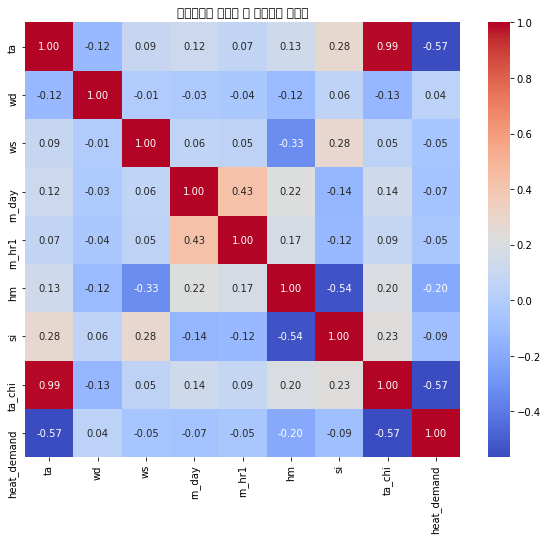

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt

# 상관관계 계산
corr = heat[['ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si', 'ta_chi', 'heat_demand']].corr()

# 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("기상변수와 열수요 간 상관관계 히트맵")
plt.show()


기온이랑 상대습도가 열수요에 가장 많은 영향을 미침.